In [1]:

# === Q1: DATA CLEANING ===

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("nba_2022-23_stats.csv")
print("Shape:", df.shape)
display(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Decide what’s odd
print("\nDataset info:")
df.info()

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
X = df[numeric_cols].copy()

# Fill missing values with median
X = X.fillna(X.median())

# Detect outliers (Z-score > 6)
z = np.abs(stats.zscore(X, nan_policy='omit'))
outliers = (z > 6).any(axis=1)
print(f"Outliers detected: {outliers.sum()}")

# Drop duplicates
X = X.drop_duplicates()
print("After removing duplicates:", X.shape)

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Final cleaned data shape:", X_scaled.shape)



Shape: (467, 52)


,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,...,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,...,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,...,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,...,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,...,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9



Missing values per column:
FG%      1
3P%     13
2P%      4
eFG%     1
FT%     23
TS%      1
3PAr     1
FTr      1
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     467 non-null    int64  
 1   Player Name    467 non-null    object 
 2   Salary         467 non-null    int64  
 3   Position       467 non-null    object 
 4   Age            467 non-null    int64  
 5   Team           467 non-null    object 
 6   GP             467 non-null    int64  
 7   GS             467 non-null    int64  
 8   MP             467 non-null    float64
 9   FG             467 non-null    float64
 10  FGA            467 non-null    float64
 11  FG%            466 non-null    float64
 12  3P             467 non-null    object 
 13  3PA            467 non-null    float64
 14  3P%            454 non-null    float64
 15

In [2]:
# === Autoencoder (PyTorch version) ===
import torch
import torch.nn as nn
import torch.optim as optim

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

model = Autoencoder(X_tensor.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(50):
    optimizer.zero_grad()
    recon, z = model(X_tensor)
    loss = loss_fn(recon, X_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# Extract 2D latent representation
with torch.no_grad():
    _, Z_ae = model(X_tensor)
Z_ae = Z_ae.numpy()
print("Autoencoder (PyTorch) latent shape:", Z_ae.shape)



Epoch 10: Loss = 0.9597
Epoch 20: Loss = 0.7202
Epoch 30: Loss = 0.5734
Epoch 40: Loss = 0.4918
Epoch 50: Loss = 0.4170
Autoencoder (PyTorch) latent shape: (467, 2)


In [3]:
from minisom import MiniSom
Z_10 = torch.relu(model.encoder[:-1](X_tensor)).detach().numpy()  # use hidden layer features (≈10-D)
som = MiniSom(20, 20, Z_10.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
som.train_random(Z_10, 200)
Z_som = np.array([som.winner(x) for x in Z_10])
print("AE + SOM 2-D shape:", Z_som.shape)


AE + SOM 2-D shape: (467, 2)


In [4]:
from sklearn.manifold import TSNE
Z_tsne = TSNE(n_components=2, random_state=42).fit_transform(Z_10)
print("AE + t-SNE 2-D shape:", Z_tsne.shape)


AE + t-SNE 2-D shape: (467, 2)


In [5]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42)
Z_umap = reducer.fit_transform(Z_10)
print("AE + UMAP 2-D shape:", Z_umap.shape)



c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


AE + UMAP 2-D shape: (467, 2)


In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.fc_dec1 = nn.Linear(latent_dim, 128)
        self.fc_dec2 = nn.Linear(128, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc_dec1(z))
        return self.fc_dec2(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae = VAE(X_tensor.shape[1])
optimizer = optim.Adam(vae.parameters(), lr=0.001)

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kl_loss) / x.size(0)

for epoch in range(50):
    optimizer.zero_grad()
    recon, mu, logvar = vae(X_tensor)
    loss = vae_loss(recon, X_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

with torch.no_grad():
    _, Z_vae_mu, _ = vae(X_tensor)
Z_vae = Z_vae_mu.numpy()
print("VAE latent 2-D shape:", Z_vae.shape)


Epoch 10: Loss = 45.8256
Epoch 20: Loss = 34.7454
Epoch 30: Loss = 32.0781
Epoch 40: Loss = 29.6456
Epoch 50: Loss = 28.0585
VAE latent 2-D shape: (467, 2)


Autoencoder: best k = 5, silhouette = 0.4010


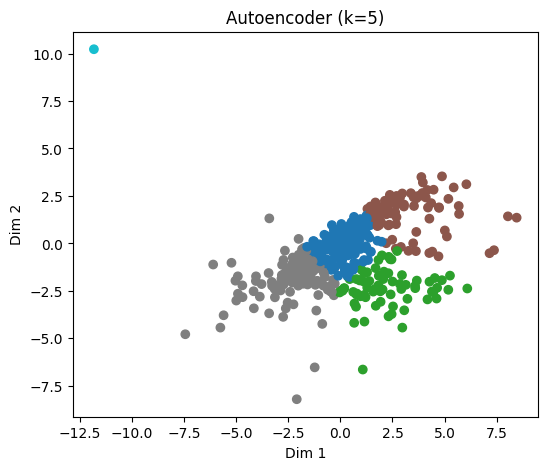

AE + SOM: best k = 3, silhouette = 0.6506


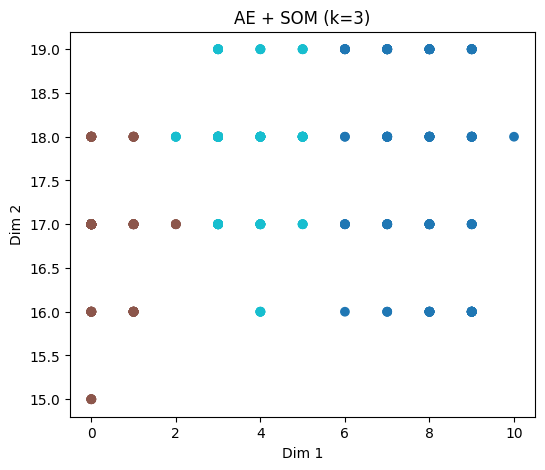

AE + t-SNE: best k = 2, silhouette = 0.5066


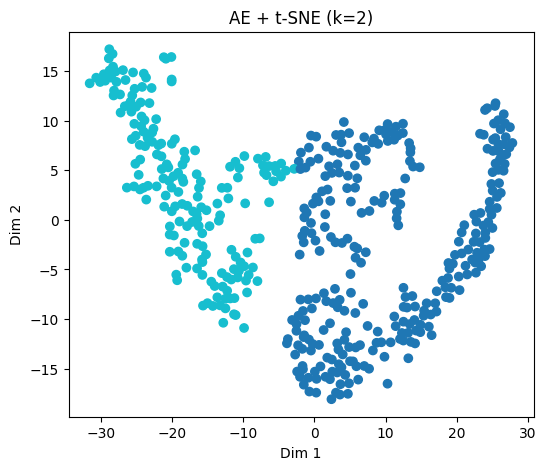

AE + UMAP: best k = 6, silhouette = 0.5450


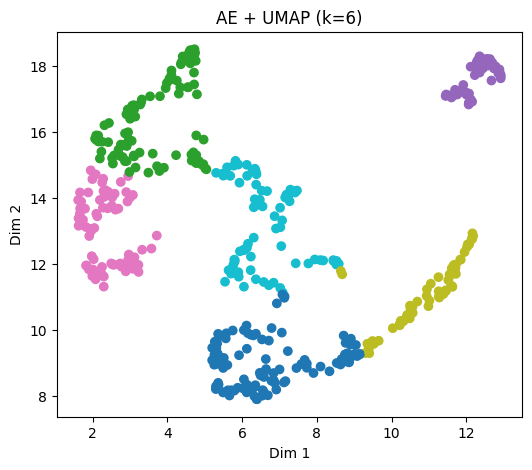

VAE: best k = 2, silhouette = 0.8685


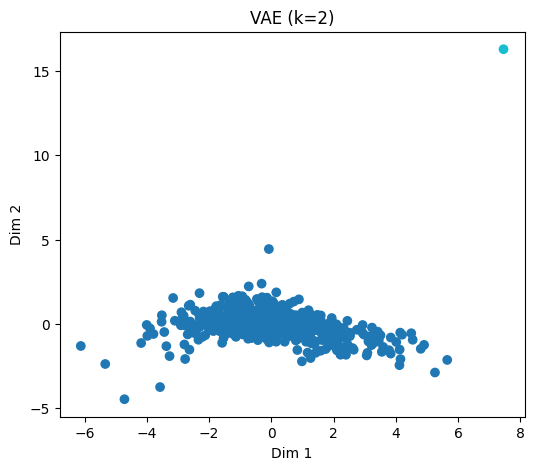

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

embeddings = {
    "Autoencoder": Z_ae,
    "AE + SOM": Z_som,
    "AE + t-SNE": Z_tsne,
    "AE + UMAP": Z_umap,
    "VAE": Z_vae
}

for name, Z in embeddings.items():
    best_score, best_k = -1, 0
    for k in range(2, 7):
        km = KMeans(n_clusters=k, random_state=42)
        labels = km.fit_predict(Z)
        score = silhouette_score(Z, labels)
        if score > best_score:
            best_score, best_k = score, k
    print(f"{name}: best k = {best_k}, silhouette = {best_score:.4f}")

    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], c=KMeans(n_clusters=best_k, random_state=42).fit_predict(Z), cmap='tab10')
    plt.title(f"{name} (k={best_k})")
    plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
    plt.show()
